In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [3]:
from utils import gen_data, gen_covariance, sparsify_beta, gen_beta2

In [7]:
root_dir = '/mnt/sdb1'

In [8]:
lasso = pd.read_pickle('%s/finalfinal/lasso_concat_df.dat' % root_dir)
mcp = pd.read_pickle('%s/finalfinal/mcp_concat_df.dat' % root_dir)
scad = pd.read_pickle('%s/finalfinal/scad_concat_df.dat' % root_dir)
en = pd.read_pickle('%s/finalfinal/en_concat_df.dat' % root_dir)

In [9]:
from plotting_utils import *
import h5py

In [10]:
sparsity = np.unique(lasso['sparsity'].values)

In [11]:
import pickle

In [12]:
# Load precalculated ss and eigenvalue bounds
with open('eigenvalue_ss.dat', 'rb') as f:
    eigenvalue_bounds = pickle.load(f)
    ss = pickle.load(f)

In [13]:
with open('alpha_datalist.dat', 'rb') as f:
    alpha_datalist = pickle.load(f)

### Calculation and initial plotting

In [13]:
def calc_eta_sa(cov_indices, df, flag, threshold=1):
    t0 = time.time()
    eta = np.zeros(len(cov_indices))    
    sa = np.zeros((len(cov_indices)))

    for i, cov_idx in enumerate(cov_indices):

        df_ = apply_df_filters(df, cov_idx=cov_idx)        
        
        # Calculate the alpha associated with this unique combination of model parameters
        sigma, cov_param = load_covariance(cov_idx)
        rho = 1/bound_eigenvalue(np.linalg.inv(sigma), int(df_.iloc[0]['sparsity'] * df_.iloc[0]['n_features']))            

        # take the minimum non-zero beta value
        beta = gen_beta2(df_.iloc[0]['n_features'], df_.iloc[0]['n_features'], 
                         1, df_.iloc[0]['betawidth'], seed=1234, distribution='normal')        
        
        # Sparsify beta
        beta = sparsify_beta(beta[np.newaxis, :], cov_param['block_size'], df_.iloc[0]['sparsity'],
                             seed = cov_param['block_size'])

        beta = beta.ravel()
        
        k = np.nonzero(beta)[0]

        if len(k) > 0 and len(k) < beta.size:            
            eta[i] = calc_irrep_const(sigma, k)
        else:
            eta[i] = np.nan

        # Just return the average selection accuracy
        if flag is None:
            sa[i] = np.mean(df_['sa'].values)

        if flag == 'threshold':
            sa[i] = np.count_nonzero(1 * df_['sa'].values > threshold)/len(cov_indices[i])
    
    return eta, sa

In [26]:
# Pre-sparsifty the beta for inverse exponential distribution and save away, as this is a time sink
sparse_beta = []
cov_idxs = np.arange(120)
for k, s in enumerate(sparsity):            
    for cov_idx in cov_idxs:
        _, cov_param = load_covariance(cov_idx, path='/home/akumar/nse')
        # take the minimum non-zero beta value
        beta = gen_beta2(500, 500, 
                         1, -1, seed=1234, distribution='normal')        
        # Sparsify beta
        beta = sparsify_beta(beta, cov_param['block_size'], s,
                             seed = cov_param['block_size'])
        sparse_beta.append({'sparsity': s, 'cov_idx': cov_idx, 'beta': beta})

In [31]:
cov_params = [] 
for cov_idx in np.arange(120):
    _, cp = load_covariance(cov_idx, path = '/home/akumar/nse')
    cov_params.append(cp)

In [27]:
sparse_beta = pd.DataFrame(sparse_beta)

In [37]:
# Eigenvalue constant
def calc_alpha_sa(cov_indices, df, rho, ss_, flag, threshold=1):
    t0 = time.time()
    alphas = np.zeros(len(cov_indices))    
    sa = np.zeros((len(cov_indices)))
    for i, cov_idx in enumerate(cov_indices):
        df_ = apply_df_filters(df, cov_idx=cov_idx)        
        cov_param = cov_params[cov_idx]

        # Use pregenerated beta for inverse exp due to slow time for rejection sampling
        if df_.iloc[0]['betawidth'] == -1:
            sb = apply_df_filters(sparse_beta, cov_idx=cov_idx, sparsity=df.iloc[0]['sparsity'])
            beta = sb.iloc[0]['beta']
        else:
            # take the minimum non-zero beta value
            beta = gen_beta2(df_.iloc[0]['n_features'], df_.iloc[0]['n_features'], 1, df_.iloc[0]['betawidth'], seed=1234, distribution='normal')                
            # Sparsify beta
            beta = sparsify_beta(beta[np.newaxis, :], cov_param['block_size'], df_.iloc[0]['sparsity'], seed = cov_param['block_size'])

        beta=beta.ravel()

        alphas[i] = np.mean(rho[i] * np.min(np.abs(beta[np.nonzero(beta)[0]]))/ss_[i])

        # Just return the average selection accuracy
        if flag is None:
            sa[i] = np.mean(df_['sa'].values)

        if flag == 'threshold':
            sa[i] = np.count_nonzero(1 * df_.iloc[cov_indices[i]]['sa'].values > threshold)/len(cov_indices[i])
           
    return alphas, sa

In [43]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
betawidth = np.unique(lasso['betawidth'].values)
selection_methods = np.unique(lasso['selection_method'])
dframes = [lasso, mcp, scad, en]
#dframes = [uoi, en]
dframe_names = ['Lasso', 'MCP', 'SCAD', 'EN']

# Need to create a dataframe 
alpha_datalist = []

for i, dframe in enumerate(dframes):                
    for j, bw in enumerate(betawidth):
        t0 = time.time() 
        for h, sm in enumerate(selection_methods):
            for k, s in enumerate(sparsity):            
                df = apply_df_filters(dframe, kappa=kappa, np_ratio=np_ratio, selection_method=sm,
                                      betawidth=bw, sparsity=s)
                cov_indices = np.unique(df['cov_idx'].values) 
                alpha_, sa_ = calc_alpha_sa(cov_indices, df, rho=eigenvalue_bounds[:, k],
                                            ss_=ss[:, k, j], flag=None) 
                alpha_datalist.append({'df_name' : dframe_names[i], 'betawidth': bw, 'sparsity' : s,
                                       'alpha': alpha_, 'sa': sa_, 'selection_method': sm})       
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

Dataframe: Lasso, bw_idx: 0, time: 89.340735
Dataframe: Lasso, bw_idx: 1, time: 88.237169
Dataframe: Lasso, bw_idx: 2, time: 88.406099
Dataframe: MCP, bw_idx: 0, time: 102.296091
Dataframe: MCP, bw_idx: 1, time: 82.403285
Dataframe: MCP, bw_idx: 2, time: 88.388150
Dataframe: SCAD, bw_idx: 0, time: 87.907823
Dataframe: SCAD, bw_idx: 1, time: 91.980231
Dataframe: SCAD, bw_idx: 2, time: 87.463562
Dataframe: EN, bw_idx: 0, time: 93.692573
Dataframe: EN, bw_idx: 1, time: 96.026144
Dataframe: EN, bw_idx: 2, time: 93.089274


In [75]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'BIC'

dframes = [lasso, mcp, scad, en]
#dframes = [uoi, en]
dframe_names = ['Lasso', 'MCP', 'SCAD', 'EN']

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary
eta = []
sa_eta = []

for i, dframe in enumerate(dframes):
    t0 = time.time()
    eta.append([])
    sa_eta.append([])
        
    for j, bw in enumerate(betawidth):
        for k, s in enumerate(sparsity):
            df = apply_df_filters(dframe, kappa=kappa, np_ratio=np_ratio, selection_method=selection_method,
                                  betawidth=bw, sparsity=s)
            cov_indices = np.unique(df['cov_idx'].values)
            eta_, sa_ = calc_eta_sa(cov_indices, df, flag=None) 
            eta[i].extend(eta_)
            sa_eta[i].extend(sa_)
            
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Dataframe: Lasso, bw_idx: 0, time: 944.877535
Dataframe: Lasso, bw_idx: 1, time: 1564.140131
Dataframe: Lasso, bw_idx: 2, time: 2184.625480
Dataframe: MCP, bw_idx: 0, time: 945.298219
Dataframe: MCP, bw_idx: 1, time: 1568.598998
Dataframe: MCP, bw_idx: 2, time: 2191.347532
Dataframe: SCAD, bw_idx: 0, time: 948.724759
Dataframe: SCAD, bw_idx: 1, time: 1570.271118
Dataframe: SCAD, bw_idx: 2, time: 2191.776856
Dataframe: EN, bw_idx: 0, time: 944.455778
Dataframe: EN, bw_idx: 1, time: 1566.170808
Dataframe: EN, bw_idx: 2, time: 2187.949424


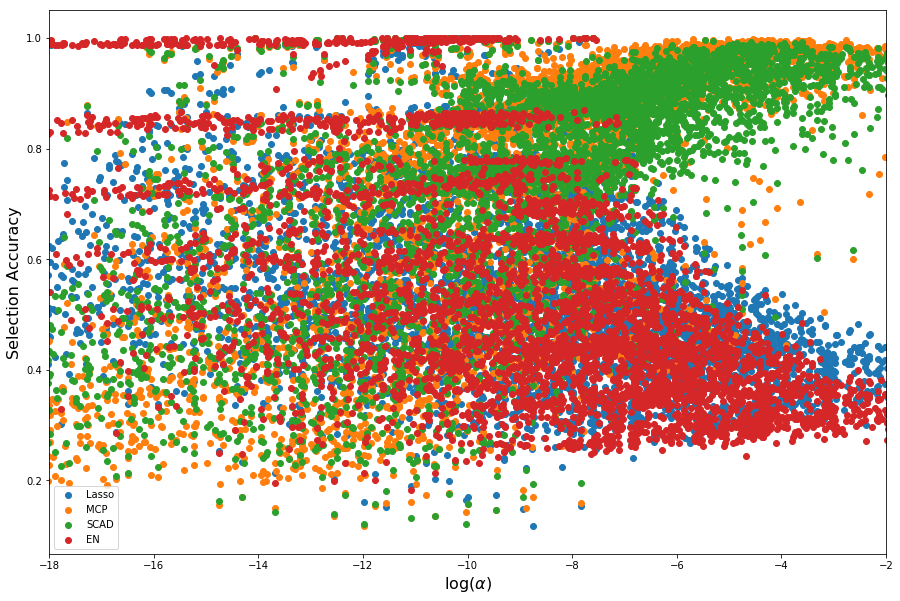

In [79]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
k = 5
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'BIC'

dframes = [lasso, mcp, scad, en]
#dframes = [uoi, en]
dframe_names = ['Lasso', 'MCP', 'SCAD', 'EN']

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
pal_colors = cols


fig, ax = plt.subplots(figsize=(15, 10))

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

for i, dframe in enumerate(dframes):        
    ax.scatter(np.ma.log(alpha[i]), sa[i], label=dframe_names[i])
    
ax.set_xlim([-18, -2])
ax.set_ylabel('Selection Accuracy', fontsize=16)
ax.set_xlabel(r'$\log(\alpha)$', fontsize=16)
ax.legend()

plt.savefig('n_scalingCV.pdf', bbox_inches='tight', pad_inches=0)

In [37]:
betawidth

array([-1. ,  0.1,  inf])

In [98]:
# To avoid redundant computations, for all unique covariance matrices and sparsity patterns, calculate the 
# eigenvalue bound.

eigenvalue_bounds = np.zeros((120, sparsity.size))

ss = np.zeros((120, sparsity.size, betawidth.size))


for cov_idx in np.arange(120):
    t0 = time.time()
    print(cov_idx)
    for i, s in enumerate(sparsity):
        sigma, cov_param = load_covariance(cov_idx)
        rho = 1/bound_eigenvalue(np.linalg.inv(sigma), int(s * 500))            
        eigenvalue_bounds[cov_idx, i] = rho

        for j, bw in enumerate(betawidth):
            df_ = apply_df_filters(lasso, kappa=kappa, selection_method=selection_method, 
                                   betawidth = bw, cov_idx=cov_idx, sparsity=s)
            if df_.shape[0] == 0:
                ss[cov_idx, i, j] = np.nan
                print('Skipped for sparsity %f' % s)
                continue
            else:                
                beta = gen_beta2(df_.iloc[0]['n_features'], df_.iloc[0]['n_features'], 1, 
                                 df_.iloc[0]['betawidth'], seed=1234, distribution='normal')        

                # Sparsify beta
                beta = sparsify_beta(beta[np.newaxis, :], cov_param['block_size'], 
                                     df_.iloc[0]['sparsity'], seed = cov_param['block_size'])
                beta = beta.ravel()
                _, _, _, _, ss_ = gen_data(df_.iloc[0]['n_samples'], df_.iloc[0]['n_features'], 
                                          df_.iloc[0]['kappa'], sigma, beta, seed=df_.iloc[0]['seed'])

                ss[cov_idx, i, j] = ss_        
    print(time.time() - t0)

0
36.93020963668823
1
36.20541310310364
2
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
35.23443794250488
3
36.35863447189331
4
36.255539894104004
5
36.39898872375488
6
35.60279083251953
7
35.408637046813965
8
36.35075664520264
9
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
34.98666477203369
10


/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
34.106616258621216
11
37.03086614608765
12
35.69741749763489
13
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
33.07948684692383
14
35.05943298339844
15
35.19422483444214
16
35.22118782997131
17
34.481879472732544
18
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
33.75317573547363
19

Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
36.011515855789185
82
37.85241627693176
83
37.94790172576904
84
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
36.188886880874634
85
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
Skipped for sparsity 0.034974
36.568116664886475
86
38.29466462135315
87
38.18590331077576
88
37.91229295730591
89
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.020000
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.026448
Skipped for sparsity 0.034974
Skipped for sparsit

### Plotting

#### First set of plots: one for each of the selection methods

In [40]:
alpha_datalist = pd.DataFrame(alpha_datalist)

In [41]:
list(alpha_datalist.keys())

['df_name', 'betawidth', 'sparsity', 'alpha', 'sa']

KeyError: 'selection_method'

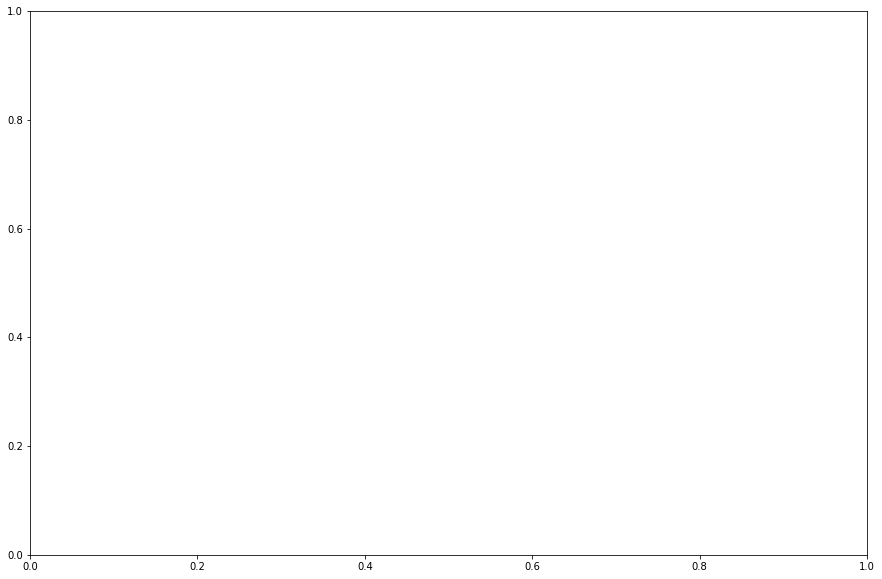

In [18]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
selection_method = 'BIC'
dframe_names = np.unique(alpha_datalist['df_name'].values)

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
pal_colors = cols

fig, ax = plt.subplots(figsize=(15, 10))

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

for i, dframe in enumerate(dframe_names):        
    rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                            np_ratio=np_ratio, kappa=kappa)
    pdb.set_trace()
    ax.scatter(np.ma.log(alpha[i]), sa[i], label=dframe_names[i])
    
ax.set_xlim([-18, -2])
ax.set_ylabel('Selection Accuracy', fontsize=16)
ax.set_xlabel(r'$\log(\alpha)$', fontsize=16)
ax.legend()